<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-01/index_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 01 - Linear Classification




In [156]:
!pip install demoji

     |████████████████████████████████| 42 kB 1.1 MB/s 


## Imports

In [250]:
import csv
import re
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 200)   
pd.set_option('display.width', 4000) 

from io import StringIO
import requests
import matplotlib.pyplot as plt

import demoji

In [4]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

## Functions

## 1. Data Acquisition

In [5]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [13]:
train_data = load_dataset(url_train_dev)
test_data = load_dataset(url_test)

## 2. Data Exploration

In [279]:
def data_exploration(df, name=''):
  '''

  '''
  print('--- {} ---'.format(name))
  n_labels = len(np.unique(df["label"]))
  df = df.sort_values('label')
  print("{0} contains the columns: {1}".format(name, list(df.keys())))
  print("with a total of {} observations".format(len(df)))
  print("and {} different possible labels.".format(n_labels))
  print("The unique labels are {}".format(df["label"].unique()))
  plt.figure(figsize=(15, 3))
  plt.hist(df["label"], bins=n_labels)
  plt.xticks(rotation=90)
  plt.yscale("log")
  plt.xlabel("Language")
  plt.ylabel("#Occurences")
  plt.show()

--- Training data ---
Training data contains the columns: ['tweet', 'label']
with a total of 52675 observations
and 69 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr' 'ht'
 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN' 'ms'
 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt' 'ro' 'ru' 'si' 'sl' 'sq' 'sr'
 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th' 'tl' 'tn' 'tr' 'uk' 'und' 'ur'
 'ur_LATN' 'vi' 'wo' 'xh' 'zh-CN' 'zh-TW']


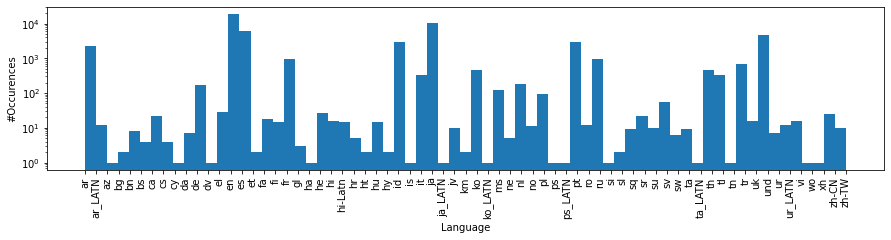

In [280]:
data_exploration(train_data, 'Training data')

--- Test data ---
Test data contains the columns: ['tweet', 'label']
with a total of 13279 observations
and 60 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bs' 'ca' 'cs' 'da' 'de' 'el' 'en' 'es' 'eu'
 'fa' 'fi' 'fr' 'he' 'hi' 'hi-Latn' 'hr' 'ht' 'id' 'it' 'ja' 'ja_LATN'
 'jv' 'km' 'ko' 'ko_LATN' 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'nl' 'no' 'pl'
 'pt' 'ro' 'ru' 'sk' 'sr' 'sv' 'sw' 'ta' 'ta_LATN' 'th' 'tl' 'tr' 'uk'
 'und' 'ur' 'ur_LATN' 'vi' 'xh' 'yo' 'zh-CN' 'zh-TW' 'zu']


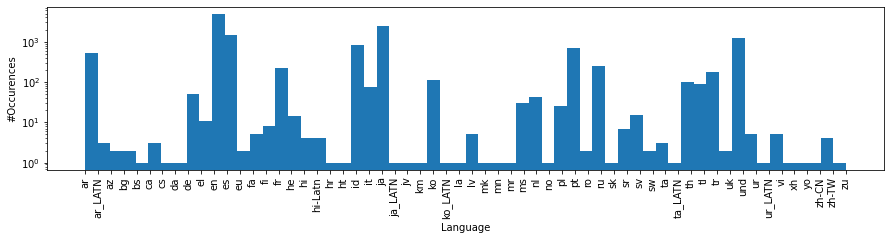

In [281]:
data_exploration(test_data, 'Test data')

In [282]:
# Now we want to find out which special characters need to be removed from tweets in order to make the prediction better.
# We go over the printed list an not down the symbold which are not needed for language identification.
# These will be removed in a later step.
languages = list(np.unique(test_data['label']))
for language in languages:
  localized_tweets = train_data[train_data['label'] == language]
  print(localized_tweets.head(5))
  print("---")

# Symbols like @<mention>, #, http://link !, numeric values (e.g 16000), " do not help for language identification.

                                                                                                                tweet label
0    يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع أن يتكلما    يا قلبي الدامي وآه وأين ومن   فاضت على عواطفاً وترحما    ar
1                                    فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وبين حماس  ؟  هنفهم وﻻ نبدا من ا ب ت    ar
2  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ف  ﺣﺎﺟﺎﺕ ﺣﻠﻮﺓ ﺑﺘﺘﻤﻨﺎﻫﺎ  ﻭﺗﻔﺘﺢ ﻋﻴﻨﻴﻚ .. ﺑﻀﺤﻜﺔ ﺟﻤﻴﻠﺔ .   ﻣﻊ ﻛﻠﻤﺔ #يارب    ar
3                                                                                                   يا ابو سلو عرفتني    ar
4             ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله مثل أجر عمرته وتفطيره وصلواته بالحرمhttp://t.co/jQoUiiVPjX    ar
---
                                         tweet    label
2199                      ya allah ya allah x)  ar_LATN
2200                   Ya rab tekhlas hel game  ar_LATN
2201                           Istaqfurullah 😂  ar_LATN
2202  @g56_ 7abeeebbbbbie en

## 3. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model.

In [263]:
def remove_all_emojis(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

In [267]:
def  clean_text(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [268]:
test_clean = clean_text(test_data, "tweet")
train_clean = clean_text(train_data, "tweet")

In [290]:
test_data_comparison = pd.concat([test_data.drop(['label'], axis=1), test_clean], axis=1)
test_data_comparison.sample(20, axis=0)

,tweet,tweet,label
4912,#BestMassageEver 😝 GO WATCH @camerondallas 's NEW HILARIOUS VIDEO 😝 http://t.co/0RkgQmCRt4 😝 GIVE IT A 👍 😝 &amp; SUBSCRIBE 😝 ILY PLEASE😭 73,go watch s new hilarious video give it a subscribe ily please,en
9653,"get ready with drinks and food,can't wait to start this great battle #CafeRio #WordCup2014 #FIFA2014 #sonysix #Brazil2014",get ready with drinks and foodcant wait to start this great battle,en
7558,@hhss57722 おやすみなさい.さん…,おやすみなさいさん…,ja
12376,日中があまり暑くならなそうで、仕上げ摘果がんばらんと。今年は色々で遅れてる。,日中があまり暑くならなそうで、仕上げ摘果がんばらんと。今年は色々で遅れてる。,ja
2190,Baytown Webster McDonalds is the worst ever!!!,baytown webster mcdonalds is the worst ever,en
1154,@claudiaoxoxo aww man you should have tried to get me an autograph 😉hope you're having a good time xxx,aww man you should have tried to get me an autograph hope youre having a good time xxx,en
563,@DM_Gell @Ricardo_Arjona,,und
4231,Looking thru my calendar 4the week and happily discovering that I will have time 2 #standwithgaza because My kid will B at Jewish day camp.,looking thru my calendar the week and happily discovering that i will have time because my kid will b at jewish day camp,en
11620,O cara não entende que não to afim de falar com ele e fica me mandando mensagem no face,o cara não entende que não to afim de falar com ele e fica me mandando mensagem no face,pt
4813,@nunuuSN follback yee,follback yee,und


In [291]:
train_data_comparison = pd.concat([train_data.drop(['label'], axis=1), train_clean], axis=1)
train_data_comparison.sample(20, axis=0)

,tweet,tweet,label
22327,y todo sabe a despedida y mis labios saben a alcohol,y todo sabe a despedida y mis labios saben a alcohol,es
51145,Braaaa 😐😩,braaaa,und
19442,#shoptattoo #pen #gel @ ShopTattoo http://t.co/8Lvc3h7EC2,shoptattoo,en
33472,[目指せ三ツ星ハンター]「50は平気」(コルトピ) 「HUNTER×HUNTER バトルオールスターズ」 ダウンロードはこちら⇒ http://t.co/SbiLjv3l4L #HHBAS,目指せ三ツ星ハンター「は平気」コルトピ 「hunter×hunter バトルオールスターズ」 ダウンロードはこちら⇒,ja
31047,@LorenzoBises la tiella &lt;3 nonna è una maestra. I caniscioni ripieni di formaggio fresco non li hai mangiati vero?,la tiella nonna è una maestra i caniscioni ripieni di formaggio fresco non li hai mangiati vero,it
40245,@SNSD_raily57 いえいえ(●´ω｀●) それはないない、りっちゃんには負ける。 したいよー(´-ω-｀)♡,いえいえ●´ω｀● それはないない、りっちゃんには負ける。 したいよー´ω｀♡,ja
18926,@Miaknowsbest_ lmao wow ily 😂,lmao wow ily,en
17246,3am 4 catfish and 1 largemouth that some Mexicans gave me and Mike is passed out missing it,am catfish and largemouth that some mexicans gave me and mike is passed out missing it,en
42020,너희들이 좋아하는 내 노래있어?커버곡이겠지만...,너희들이 좋아하는 내 노래있어커버곡이겠지만,ko
7793,Family over everything. http://t.co/mhwHYpllF1,family over everything,en


# 4.Data Augmentation

## 4.1 Back translation

In [284]:
! pip install transformers
! pip install mosestokenizer
! pip install SentencePiece

     |████████████████████████████████| 2.9 MB 6.7 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 895 kB 36.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 636 kB 41.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for mosestokenizer: filename=mosestokenizer-1.1.0-py3-none-any.whl size=49117 sha256=afa01154e7dc242dfc4287f3de2dc95980affe66336277b2da2936285d53685d
  Stored in directory: /root/.cache/pip/wheels/a7/31/94/fef279382208e85a65c1a7f5c4d0020115477b0af74f296b57
  Created wheel for toolwrapper: filename=toolwrapper-2.1.0-py3-none-any.whl size=3354 sha256=958bd3b671b269e1e1107585298c778ae66e9258b766df57012b3c1e7de750ed
  Stored in directory: /root/.cache/pip/wheels/c5/4f/33/54741ffe08e38ececb1d28068a153729b4fe820bafa0a0691f
  Created wheel for uctoo

In [ ]:
import transformers, mosestokenizer

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Helper function to download data for a language
def download(model_name):
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    return tokenizer, model



# download model for English -> Romance
#tmp_lang_tokenizer, tmp_lang_model = download('Helsinki-NLP/opus-mt-en-ROMANCE')
# download model for Romance -> English
#src_lang_tokenizer, src_lang_model = download('Helsinki-NLP/opus-mt-ROMANCE-en')



def translate(texts, model, tokenizer, language):
    """Translate texts into a target language"""
    # Format the text as expected by the model
    formatter_fn = lambda txt: f"{txt}" if language == "en" else f">>{language}<< {txt}"
    original_texts = [formatter_fn(txt) for txt in texts]

    # Tokenize (text to tokens)
    tokens = tokenizer.prepare_seq2seq_batch(original_texts)

    # Translate
    translated = model.generate(**tokens)

    # Decode (tokens to text)
    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)

    return translated_texts


def back_translate(texts, language_src, language_dst):
    """Implements back translation"""
    # Translate from source to target language
    translated = translate(texts, tmp_lang_model, tmp_lang_tokenizer, language_dst)

    # Translate from target language back to source language
    back_translated = translate(translated, src_lang_model, src_lang_tokenizer, language_src)

    return back_translated




In [ ]:
model_name = 'Helsinki-NLP/opus-mt-aav-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
tokenizer.supported_language_codes

AttributeError: ignored

In [ ]:
language_code_list =df_train_dev['label'].unique

def get_one_language_data(df, n):
  #get the n'th set of language from df_train_dev
  df_one_lang=df[df['label'].isin([language_code_list[n]])]
  return df_one_lang

def generate_new_rows(df_one_lang):
  lable=df_one_lang['label']
  df_one_lang_new = pd.DataFrame(columns=['text','label'])
  for rows in df_one_lang.itterows():
    new_lang = back_translate(df_one_lang['text'],label,'en')
    df_one_lang_new.append({'text':new_lang,'label'label})
    df_one_lang=df_one_lang.append(df_one_lang_new)
  return df_one_lang

def augdata_by_back_translation(df):
  df_new = pd.DataFrame(columns=['text','label'])
  for n in range(0,len(language_code_list)):
    df_one_lang_new = generate_new_rows(get_one_language_data(df,n))
    df_new = df_new.append(df_one_lang_new)
  return df_new



,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar
...,...,...
52670,其實我很想問，噗浪怎麼鎖回應然後又開啟的#### http://t.co/sQBh6jmVoW,zh-TW
52671,我喜歡一部 @YouTube 影片 http://t.co/Kouv0xaEos FIGHT...,zh-TW
52672,一分鐘世界盃！http://t.co/yEvaMrp7ki,zh-TW
52673,{CWB} 桃園縣 一週天氣預報(07/27 05:00發布): 07/27 白天 溫度:2...,zh-TW


![back_translation.png](attachment:back_translation.png)

## 2.2 Bigram flipping














In [ ]:
def augdata_by_bigram_flipping(df):

  return df_new

##  2.3 Replacing Entities

In [ ]:
def augdata_by_replacing_entities(df):

  return df_new

# 5.Pre-Processing

# 6.Feature Engineering


# 7.Modeling 

#8.Evaluation